## **Part 3: Are Prompts a Stable Control Knob for DA/DG with CLIP?**

### **3.1. Overview**

This task is a more open-ended and research-focused exploration into leveraging pre-trained vision-language models like **CLIP** to handle domain shifts. We will investigate prompt learning and gradient alignment as state-of-the-art approaches.

The goal is to understand how we can combine the strong, general-purpose features from a large pre-trained model with domain-specific adaptation techniques to build a robust system.

---

## **Part 1: CLIP Zero-Shot vs. Fine-Tuning**

### **1.1. Overview**

As per the assignment, we first need to evaluate the out-of-the-box (zero-shot) performance of a pre-trained CLIP model on our chosen dataset, **PACS**. This will establish a powerful baseline.

Next, we will perform a simple fine-tuning by treating CLIP's image encoder as a frozen feature extractor and training a linear classifier (a "linear probe") on top of it using our source domains (**Art, Cartoon, Photo**). We'll then evaluate this probe on all domains, including the unseen target domain (**Sketch**), to see if fine-tuning helps or hurts generalization.

### **1.2. Environment Setup & Data Loading (Standard PyTorch)**

First, let's set up our environment. We'll install the `clip` library, `torch`, and `torchvision`. Instead of DomainBed, we will use `torchvision.datasets.ImageFolder` to load the PACS data directly.

In [ ]:
# ============================================
# 📦 Imports and Environment Setup
# ============================================
import os
from pathlib import Path

import clip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_curve
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset
from torchvision.datasets import ImageFolder

os.environ["TQDM_NOTEBOOK"] = "0"
from tqdm import tqdm

# ============================================
# ⚙️ Configuration
# ============================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

# ============================================
#  CLIP Model & Data Loading
# ============================================

# Load CLIP model and its preprocessing function
clip_model, preprocess = clip.load("ViT-B/32", device=device)
print("✅ CLIP model (ViT-B/32) loaded.")

# --- PACS Dataset Configuration ---
DATA_ROOT = "./data/PACS/"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
PACS_CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
TARGET_DOMAIN_NAME = "sketch"
TARGET_DOMAIN_IDX = DOMAINS.index(TARGET_DOMAIN_NAME)

# Create a dataset and dataloader for each domain using ImageFolder
datasets = []
dataloaders = []
for domain_name in DOMAINS:
    domain_path = os.path.join(DATA_ROOT, domain_name)
    dataset = ImageFolder(domain_path, transform=preprocess)
    datasets.append(dataset)
    dataloaders.append(DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2))
    print(f"  - Loaded '{domain_name}' with {len(dataset)} images.")

print(
    f"\n✅ Created {len(dataloaders)} dataloaders, one for each domain using ImageFolder."
)

🚀 Using device: cuda
✅ CLIP model (ViT-B/32) loaded.
  - Loaded 'art_painting' with 2048 images.
  - Loaded 'cartoon' with 2344 images.
  - Loaded 'photo' with 1670 images.
  - Loaded 'sketch' with 3929 images.

✅ Created 4 dataloaders, one for each domain using ImageFolder.


### **1.3. CLIP Zero-Shot Evaluation**

Now we'll perform the zero-shot classification. We will create text prompts from the class names and evaluate the model's accuracy on each domain without any training. As suggested, we'll try a few different prompt templates to see how sensitive performance is to the prompt's wording.

In [2]:
# ============================================
# 🎯 Zero-Shot Evaluation Function
# ============================================

def evaluate_zero_shot(model, dataloader, class_names, prompt_template, domain_name):
    """Evaluates a CLIP model in a zero-shot fashion on a given dataloader."""
    model.eval()
    correct = 0
    total = 0
    
    # Create text features from prompts
    with torch.no_grad():
        prompts = [prompt_template.format(c) for c in class_names]
        text_inputs = clip.tokenize(prompts).to(device)
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    pbar = tqdm(dataloader, desc=f"🔎 Evaluating {domain_name} with prompt: '{prompt_template.format('...')}'")
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Create image features
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
            # Calculate similarity and make predictions
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            preds = similarity.argmax(dim=-1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix({'acc': f"{100*correct/total:.2f}%"})
    
    return 100 * correct / total

# --- Run Zero-Shot Experiments ---
prompt_templates = [
    "a photo of a {}.",
    "a sketch of a {}.",
    "an artwork of a {}.",
    "a painting of a {}.",
    "a drawing of a {}."
]

results = []
for i, loader in enumerate(dataloaders):
    domain_name = DOMAINS[i]
    domain_results = {'Domain': domain_name}
    for template in prompt_templates:
        acc = evaluate_zero_shot(clip_model, loader, PACS_CLASSES, template, domain_name)
        template_key = template.split(" ")[1] # e.g., 'photo'
        domain_results[f"'{template_key}' prompt"] = acc
    results.append(domain_results)

# --- Display Results ---
zero_shot_df = pd.DataFrame(results).set_index('Domain')
print("\n📊 Zero-Shot Classification Accuracy (%)\n")
display(zero_shot_df.style.format("{:.2f}").background_gradient(cmap='viridis', axis=1))

🔎 Evaluating art_painting with prompt: 'a photo of a ....': 100%|██████████| 32/32 [00:08<00:00,  3.85it/s, acc=96.68%]
🔎 Evaluating art_painting with prompt: 'a sketch of a ....': 100%|██████████| 32/32 [00:08<00:00,  3.99it/s, acc=95.70%]
🔎 Evaluating art_painting with prompt: 'an artwork of a ....': 100%|██████████| 32/32 [00:07<00:00,  4.01it/s, acc=95.61%]
🔎 Evaluating art_painting with prompt: 'a painting of a ....': 100%|██████████| 32/32 [00:07<00:00,  4.12it/s, acc=95.51%]
🔎 Evaluating art_painting with prompt: 'a drawing of a ....': 100%|██████████| 32/32 [00:08<00:00,  3.91it/s, acc=96.00%]
🔎 Evaluating cartoon with prompt: 'a photo of a ....': 100%|██████████| 37/37 [00:08<00:00,  4.27it/s, acc=98.25%]
🔎 Evaluating cartoon with prompt: 'a sketch of a ....': 100%|██████████| 37/37 [00:08<00:00,  4.40it/s, acc=97.74%]
🔎 Evaluating cartoon with prompt: 'an artwork of a ....': 100%|██████████| 37/37 [00:08<00:00,  4.33it/s, acc=97.91%]
🔎 Evaluating cartoon with prompt: 'a paint


📊 Zero-Shot Classification Accuracy (%)



,'photo' prompt,'sketch' prompt,'artwork' prompt,'painting' prompt,'drawing' prompt
Domain,,,,,
art_painting,96.68,95.70,95.61,95.51,96.00
cartoon,98.25,97.74,97.91,97.35,97.57
photo,99.76,99.76,99.82,99.82,99.76
sketch,84.91,85.47,84.70,85.85,85.24


### **1.4. Linear Probe Fine-Tuning**

Next, we'll train a linear classifier on top of the frozen CLIP image encoder.

1.  **Feature Extraction**: First, we'll pass all images from our source domains (Art, Cartoon, Photo) through the CLIP encoder to get their feature embeddings. This is done once to save time.
2.  **Training**: Then, we'll train a simple `nn.Linear` layer on these cached features.

In [3]:
# ============================================
# 🧠 Step 1: Extract Features from Source Domains
# ============================================
source_dataloaders = [dataloaders[i] for i in range(len(DOMAINS)) if i != TARGET_DOMAIN_IDX]
source_domain_names = [DOMAINS[i] for i in range(len(DOMAINS)) if i != TARGET_DOMAIN_IDX]

all_features = []
all_labels = []

clip_model.eval()
with torch.no_grad():
    for i, loader in enumerate(source_dataloaders):
        domain_name = source_domain_names[i]
        for images, labels in tqdm(loader, desc=f"Extracting features from {domain_name}"):
            images = images.to(device)
            features = clip_model.encode_image(images)
            all_features.append(features.cpu())
            all_labels.append(labels.cpu())

# Concatenate all features and labels
train_features = torch.cat(all_features)
train_labels = torch.cat(all_labels)

print(f"\n✅ Extracted features and labels for training.")
print(f"   - Feature shape: {train_features.shape}")
print(f"   - Labels shape:  {train_labels.shape}")

# Create a new DataLoader for training the linear probe
train_dataset = TensorDataset(train_features, train_labels)
probe_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Extracting features from photo: 100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


✅ Extracted features and labels for training.
   - Feature shape: torch.Size([6062, 512])
   - Labels shape:  torch.Size([6062])


In [4]:
# ============================================
# 🏋️ Step 2: Train the Linear Probe
# ============================================

# Define the model
output_dim = len(PACS_CLASSES)
input_dim = clip_model.visual.output_dim
linear_probe = nn.Linear(input_dim, output_dim).to(device)

# Setup for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_probe.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 10

print("🚀 Starting linear probe training...")
for epoch in range(num_epochs):
    linear_probe.train()
    running_loss = 0.0
    
    pbar = tqdm(probe_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for features, labels in pbar:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # The input to the probe should be float
        outputs = linear_probe(features.float())
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
    epoch_loss = running_loss / len(probe_train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}")

print("\n✅ Linear probe training complete!")

🚀 Starting linear probe training...


Epoch 1/10: 100%|██████████| 48/48 [00:00<00:00, 188.15it/s, loss=0.5787]


Epoch 1/10, Average Loss: 1.1044


Epoch 2/10: 100%|██████████| 48/48 [00:00<00:00, 441.12it/s, loss=0.2314]


Epoch 2/10, Average Loss: 0.3531


Epoch 3/10: 100%|██████████| 48/48 [00:00<00:00, 502.27it/s, loss=0.1007]


Epoch 3/10, Average Loss: 0.2015


Epoch 4/10: 100%|██████████| 48/48 [00:00<00:00, 432.02it/s, loss=0.1379]


Epoch 4/10, Average Loss: 0.1466


Epoch 5/10: 100%|██████████| 48/48 [00:00<00:00, 493.47it/s, loss=0.1382]


Epoch 5/10, Average Loss: 0.1169


Epoch 6/10: 100%|██████████| 48/48 [00:00<00:00, 432.34it/s, loss=0.0528]


Epoch 6/10, Average Loss: 0.0973


Epoch 7/10: 100%|██████████| 48/48 [00:00<00:00, 491.51it/s, loss=0.0977]


Epoch 7/10, Average Loss: 0.0849


Epoch 8/10: 100%|██████████| 48/48 [00:00<00:00, 433.39it/s, loss=0.0412]


Epoch 8/10, Average Loss: 0.0747


Epoch 9/10: 100%|██████████| 48/48 [00:00<00:00, 496.53it/s, loss=0.1194]


Epoch 9/10, Average Loss: 0.0684


Epoch 10/10: 100%|██████████| 48/48 [00:00<00:00, 491.98it/s, loss=0.0855]

Epoch 10/10, Average Loss: 0.0620

✅ Linear probe training complete!


### **1.5. Evaluation of Linear Probe**

Finally, we evaluate (on all four domains) the performance of our trained linear probe. This will show us how well the model performs on the source domains it was trained on and, more importantly, how it generalizes to the unseen target domain (Sketch).

In [5]:
# ============================================
# 📊 Step 3: Evaluate the Linear Probe
# ============================================

def evaluate_probe(clip_model, probe_model, dataloader):
    """Evaluates a trained linear probe on a given dataloader."""
    clip_model.eval()
    probe_model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating probe"):
            images, labels = images.to(device), labels.to(device)
            
            # Get features from CLIP
            features = clip_model.encode_image(images)
            
            # Get predictions from the probe
            outputs = probe_model(features.float())
            preds = outputs.argmax(dim=-1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100 * correct / total

# --- Run Probe Evaluation ---
probe_results = {}
print("\n🔬 Evaluating trained linear probe on all domains...\n")
for i, loader in enumerate(dataloaders):
    domain_name = DOMAINS[i]
    acc = evaluate_probe(clip_model, linear_probe, loader)
    probe_results[domain_name] = acc
    print(f"   - Accuracy on {domain_name}: {acc:.2f}%")

# --- Display Comparison Table ---
probe_df = pd.DataFrame([probe_results])
probe_df.index = ["Linear Probe"]

print("\n📊 Comparison: Zero-Shot (best prompt) vs. Linear Probe Accuracy (%)\n")

# Find best accuracy for each domain from zero-shot results
best_zero_shot = zero_shot_df.max(axis=1).to_frame(name="Zero-Shot (Best Prompt)").T

# Rename columns to match for concatenation
best_zero_shot.columns = DOMAINS
probe_df.columns = DOMAINS

comparison_df = pd.concat([best_zero_shot, probe_df])
display(comparison_df.style.format("{:.2f}").background_gradient(cmap='viridis', axis=0))


🔬 Evaluating trained linear probe on all domains...



Evaluating probe: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


   - Accuracy on art_painting: 98.44%


Evaluating probe: 100%|██████████| 37/37 [00:08<00:00,  4.50it/s]


   - Accuracy on cartoon: 99.19%


Evaluating probe: 100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


   - Accuracy on photo: 99.88%


Evaluating probe: 100%|██████████| 62/62 [00:09<00:00,  6.34it/s]

   - Accuracy on sketch: 85.75%

📊 Comparison: Zero-Shot (best prompt) vs. Linear Probe Accuracy (%)



,art_painting,cartoon,photo,sketch
Zero-Shot (Best Prompt),96.68,98.25,99.82,85.85
Linear Probe,98.44,99.19,99.88,85.75


---

## **Part 2: Prompt-Learning with CLIP (CoOp)**

### **2.1. Overview**

As per the assignment, we now move to a more advanced adaptation technique: **prompt learning**. Instead of training a linear head on frozen features, we will keep the entire CLIP model frozen and instead learn a set of continuous vectors that act as a textual prompt. This method, inspired by **Context Optimization (CoOp)**, is much more parameter-efficient.

Our goal is to simulate a domain adaptation scenario. We will train these learnable prompt vectors using:
1.  **A supervised classification loss** on our labeled source domains (Art, Cartoon, Photo).
2.  **An unsupervised entropy minimization loss** on the unlabeled target domain (Sketch). This encourages the model to make confident predictions on the target data, effectively using its structure without labels.

The total loss will be $L_{total} = L_{CE} + \lambda \cdot L_{entropy}$.

### **2.2. Model Definition: Prompt Learner & Custom CLIP**

First, we define the necessary components. We need to create our own `TextEncoder` wrapper because the standard `clip_model.encode_text()` function expects token IDs, but we will be working directly with learnable prompt *embeddings*. 

1.  **`PromptLearner`**: An `nn.Module` that holds the learnable context vectors. It constructs the final prompt embeddings by combining these vectors with the embeddings of the class names.
2.  **`TextEncoder`**: A simple wrapper around CLIP's transformer that can process our custom prompt embeddings.
3.  **`CustomCLIPWithCoOp`**: The main model that integrates the frozen CLIP backbone with our learnable prompt components.

In [ ]:
# ============================================
# 🧠 Prompt Learning Components
# ============================================

class PromptLearner(nn.Module):
    def __init__(self, class_names, clip_model):
        super().__init__()
        n_cls = len(class_names)
        n_ctx = 16
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # Random initialization
        print(f'Initializing {n_ctx} context vectors randomly')
        ctx_vectors = torch.empty(n_ctx, ctx_dim)
        nn.init.normal_(ctx_vectors, std=0.02)
        
        self.ctx = nn.Parameter(ctx_vectors)  # Keep in float32!
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        
        # Create template with placeholders
        classnames = [name.replace("_", " ") for name in class_names]
        prompts = [" ".join(["X"] * n_ctx) + " " + name + "." for name in classnames]
        
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
        
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts)
        
        # These token embeddings are the same across all classes
        # [SOS] + [CTX]_n_ctx + [CLS] + [EOS]
        self.register_buffer("token_prefix", embedding[:, :1, :].float())  # SOS token
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx:, :].float())  # CLS + EOS tokens
        
        self.tokenized_prompts = tokenized_prompts

    def forward(self):
        ctx = self.ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        
        prompt_embeddings = torch.cat([
            self.token_prefix,   # (n_cls, 1, dim)
            ctx,                 # (n_cls, n_ctx, dim)
            self.token_suffix    # (n_cls, *, dim)
        ], dim=1)
        
        return prompt_embeddings


class TextEncoder(nn.Module):
    """A wrapper for CLIP's text transformer."""
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompt_embeddings, tokenized_prompts):
        # Convert input to float16 only here, right before CLIP processing
        x = prompt_embeddings.type(self.dtype) + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        
        # Take features from the EOS token
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection
        
        return x


class CustomCLIPWithCoOp(nn.Module):
    def __init__(self, class_names, clip_model):
        super().__init__()
        self.prompt_learner = PromptLearner(class_names, clip_model)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
        # Get image features in float16
        image_features = self.image_encoder(image.type(self.dtype))
        
        # Get text features - prompt_embeddings start in float32
        prompt_embeddings = self.prompt_learner()
        text_features = self.text_encoder(prompt_embeddings, self.tokenized_prompts)
        
        # Normalize (still in float16 from encoder outputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Upcast to float32 for logit calculation
        image_features = image_features.float()
        text_features = text_features.float()
        
        # Calculate logits in float32
        logit_scale = self.logit_scale.exp().float()
        logits = logit_scale * image_features @ text_features.t()
        
        return logits
        
print("✅ CoOp model components defined.")

✅ CoOp model components defined.


### **2.3. Training the Prompt Vectors**

Now we set up the training loop. We'll use a `ConcatDataset` to combine our three source domains for the supervised loss. On each step, we'll also grab a batch from the target domain (Sketch) to compute the unsupervised entropy loss.

In [7]:
# ============================================
# ⚙️ Training Setup
# ============================================

# 1. Instantiate the CoOp model
coop_model = CustomCLIPWithCoOp(PACS_CLASSES, clip_model).to(device)

# 2. Freeze all CLIP parameters, only train the prompt_learner's context vectors
for name, param in coop_model.named_parameters():
    if "ctx" not in name:
        param.requires_grad_(False)

print("✅ CLIP parameters frozen. Only training prompt vectors.")

# 3. Optimizer and Loss
optimizer = optim.AdamW(coop_model.prompt_learner.parameters(), lr=1e-2, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lambda_entropy = 1.0  # Weight for the unsupervised loss
num_epochs = 10

# 4. DataLoaders
source_indices = [i for i, name in enumerate(DOMAINS) if name != TARGET_DOMAIN_NAME]
source_datasets = [datasets[i] for i in source_indices]
source_concat_dataset = ConcatDataset(source_datasets)
source_train_loader = DataLoader(source_concat_dataset, batch_size=64, shuffle=True, num_workers=2)

target_loader = dataloaders[TARGET_DOMAIN_IDX]

print(f"📊 Training on {len(source_datasets)} source domains: {[DOMAINS[i] for i in source_indices]}")
print(f"🎯 Target domain: {TARGET_DOMAIN_NAME}")

Initializing 16 context vectors randomly
✅ CLIP parameters frozen. Only training prompt vectors.
📊 Training on 3 source domains: ['art_painting', 'cartoon', 'photo']
🎯 Target domain: sketch


In [8]:
# ============================================
# 🚀 Training Loop
# ============================================

print("\n🚀 Starting CoOp prompt learning...")
coop_model.train()

for epoch in range(num_epochs):
    target_iter = iter(target_loader) 
    running_sup_loss = 0.0
    running_unsup_loss = 0.0
    
    pbar = tqdm(source_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images_s, labels_s in pbar:
        # Get target batch, cycling the iterator if needed
        try:
            images_t, _ = next(target_iter)
        except StopIteration:
            target_iter = iter(target_loader)
            images_t, _ = next(target_iter)

        images_s, labels_s = images_s.to(device), labels_s.to(device)
        images_t = images_t.to(device)

        optimizer.zero_grad()
        
        # --- Supervised Loss (Source) ---
        logits_s = coop_model(images_s)
        loss_sup = criterion(logits_s, labels_s)
        
        # --- Unsupervised Entropy Loss (Target) ---
        logits_t = coop_model(images_t)
        probs_t = logits_t.softmax(dim=-1)
        loss_unsup = (-(probs_t * torch.log(probs_t + 1e-9)).sum(dim=1)).mean()
        
        # --- Total Loss and Backward Pass ---
        total_loss = loss_sup + (lambda_entropy * loss_unsup)
        total_loss.backward()
        
        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(coop_model.prompt_learner.parameters(), 1.0)
        
        optimizer.step()

        running_sup_loss += loss_sup.item()
        running_unsup_loss += loss_unsup.item()
        pbar.set_postfix({
            'sup_loss': f"{loss_sup.item():.3f}", 
            'unsup_loss': f"{loss_unsup.item():.3f}"
        })
        
    avg_sup_loss = running_sup_loss / len(source_train_loader)
    avg_unsup_loss = running_unsup_loss / len(source_train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Avg Sup Loss: {avg_sup_loss:.4f} | Avg Unsup Loss: {avg_unsup_loss:.4f}")

print("\n✅ CoOp training complete!")


🚀 Starting CoOp prompt learning...


Epoch 1/10: 100%|██████████| 95/95 [00:25<00:00,  3.68it/s, sup_loss=0.011, unsup_loss=0.048]


Epoch 1/10 | Avg Sup Loss: 0.0992 | Avg Unsup Loss: 0.1294


Epoch 2/10: 100%|██████████| 95/95 [00:26<00:00,  3.65it/s, sup_loss=0.035, unsup_loss=0.064]


Epoch 2/10 | Avg Sup Loss: 0.0590 | Avg Unsup Loss: 0.1217


Epoch 3/10: 100%|██████████| 95/95 [00:25<00:00,  3.72it/s, sup_loss=0.015, unsup_loss=0.073]


Epoch 3/10 | Avg Sup Loss: 0.0514 | Avg Unsup Loss: 0.1132


Epoch 4/10: 100%|██████████| 95/95 [00:25<00:00,  3.72it/s, sup_loss=0.146, unsup_loss=0.071]


Epoch 4/10 | Avg Sup Loss: 0.0508 | Avg Unsup Loss: 0.1058


Epoch 5/10: 100%|██████████| 95/95 [00:25<00:00,  3.70it/s, sup_loss=0.031, unsup_loss=0.057]


Epoch 5/10 | Avg Sup Loss: 0.0435 | Avg Unsup Loss: 0.0930


Epoch 6/10: 100%|██████████| 95/95 [00:25<00:00,  3.68it/s, sup_loss=0.078, unsup_loss=0.064]


Epoch 6/10 | Avg Sup Loss: 0.0434 | Avg Unsup Loss: 0.0870


Epoch 7/10: 100%|██████████| 95/95 [00:25<00:00,  3.74it/s, sup_loss=0.001, unsup_loss=0.062]


Epoch 7/10 | Avg Sup Loss: 0.0392 | Avg Unsup Loss: 0.0868


Epoch 8/10: 100%|██████████| 95/95 [00:25<00:00,  3.71it/s, sup_loss=0.038, unsup_loss=0.053]


Epoch 8/10 | Avg Sup Loss: 0.0387 | Avg Unsup Loss: 0.0852


Epoch 9/10: 100%|██████████| 95/95 [00:25<00:00,  3.68it/s, sup_loss=0.010, unsup_loss=0.052]


Epoch 9/10 | Avg Sup Loss: 0.0355 | Avg Unsup Loss: 0.0816


Epoch 10/10: 100%|██████████| 95/95 [00:26<00:00,  3.56it/s, sup_loss=0.007, unsup_loss=0.057]

Epoch 10/10 | Avg Sup Loss: 0.0334 | Avg Unsup Loss: 0.0778

✅ CoOp training complete!


### **2.4. Evaluation & Final Comparison**

With our prompt vectors trained, we now evaluate the adapted model on all four domains. We'll add these results to our previous comparison table to see how CoOp performs against the Zero-Shot and Linear Probe baselines.

In [9]:
# ============================================
# 📊 Evaluation
# ============================================

def evaluate_coop(coop_model, dataloader):
    """Evaluates a trained CoOp model on a given dataloader."""
    coop_model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating CoOp model"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = coop_model(images)
            preds = outputs.argmax(dim=-1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100 * correct / total

# --- Run CoOp Evaluation ---
coop_results = {}
print("\n🔬 Evaluating trained CoOp model on all domains...\n")
for i, loader in enumerate(dataloaders):
    domain_name = DOMAINS[i]
    acc = evaluate_coop(coop_model, loader)
    coop_results[domain_name] = acc
    print(f"   - Accuracy on {domain_name}: {acc:.2f}%")

# --- Display Comparison Table ---
coop_df = pd.DataFrame([coop_results])
coop_df.index = ["CoOp (Ours)"]
coop_df.columns = DOMAINS

final_comparison_df = pd.concat([comparison_df, coop_df])

print("\n📊 Final Comparison: Zero-Shot vs. Linear Probe vs. CoOp (%)\n")
display(final_comparison_df.style.format("{:.2f}").background_gradient(cmap='viridis', axis=0))


🔬 Evaluating trained CoOp model on all domains...



Evaluating CoOp model: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


   - Accuracy on art_painting: 98.34%


Evaluating CoOp model: 100%|██████████| 37/37 [00:08<00:00,  4.49it/s]


   - Accuracy on cartoon: 98.85%


Evaluating CoOp model: 100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


   - Accuracy on photo: 99.88%


Evaluating CoOp model: 100%|██████████| 62/62 [00:09<00:00,  6.27it/s]

   - Accuracy on sketch: 90.53%

📊 Final Comparison: Zero-Shot vs. Linear Probe vs. CoOp (%)



,art_painting,cartoon,photo,sketch
Zero-Shot (Best Prompt),96.68,98.25,99.82,85.85
Linear Probe,98.44,99.19,99.88,85.75
CoOp (Ours),98.34,98.85,99.88,90.53


---

## **Part 3: Gradient Conflict and Alignment**

### **3.1. Overview**

In this section, we conduct a deeper analysis into the challenges of multi-domain training, as required by Part 3 of the assignment's Task 3. When a model is trained on multiple source domains simultaneously, the optimal update direction for one domain may be detrimental to another. This phenomenon is known as **gradient conflict**[cite: 6].

To investigate this, we will:
1.  Train our `CoOp` model on two source domains simultaneously (**Art Painting** and **Cartoon**).
2.  At each training step, compute the gradients of the loss for each domain with respect to the learnable prompt parameters.
3.  Calculate the **cosine similarity** between these two gradient vectors. A negative cosine similarity indicates that the gradients are pointing in opposing directions, signifying a conflict.

This analysis will help us visualize when and why conflicts occur and provide intuition for why advanced techniques like gradient alignment might be necessary for robust domain generalization[cite: 6].

### **3.2. Setup for Gradient Analysis**

We need to set up a new training loop specifically for this analysis. We'll re-initialize our `CustomCLIPWithCoOp` model and create separate dataloaders for two source domains to compute their gradients independently.

In [10]:
# ============================================
# 🎨 Plotting Style
# ============================================
sns.set_theme(style="whitegrid")

# ============================================
# ⚙️ Re-initialize Model and Dataloaders for Analysis
# ============================================
print("Re-initializing model for gradient conflict analysis...")

# 1. Instantiate a new CoOp model to ensure fresh weights
analysis_model = CustomCLIPWithCoOp(PACS_CLASSES, clip_model).to(device)

# 2. Freeze all parameters except the learnable context vectors `ctx`
for name, param in analysis_model.named_parameters():
    if "ctx" not in name:
        param.requires_grad_(False)

# 3. Set up optimizer for the prompt learner
analysis_optimizer = optim.AdamW(analysis_model.prompt_learner.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# 4. Create separate dataloaders for two source domains: Art and Cartoon
domain_A_idx, domain_B_idx = 0, 1  # Art Painting and Cartoon

domain_A_loader = DataLoader(datasets[domain_A_idx], batch_size=32, shuffle=True, num_workers=2)
domain_B_loader = DataLoader(datasets[domain_B_idx], batch_size=32, shuffle=True, num_workers=2)

print(f"✅ Setup complete. Analyzing gradients between '{DOMAINS[domain_A_idx]}' and '{DOMAINS[domain_B_idx]}'.")

Re-initializing model for gradient conflict analysis...
Initializing 16 context vectors randomly
✅ Setup complete. Analyzing gradients between 'art_painting' and 'cartoon'.


### **3.3. Training Loop with Gradient Similarity Calculation**

Here is the core of the analysis. In this modified training loop, we perform separate backward passes for each domain's loss to isolate their gradients before making a combined update. We store the cosine similarity at each step.

In [ ]:
print("🚀 Starting training and gradient analysis...")

num_epochs_analysis = 5
max_steps = 320  # Set to run all 5 epochs (5 * 64)
cosine_similarities = []
step = 0

analysis_model.train()

for epoch in range(num_epochs_analysis):
    # Use iterators to handle domains of different lengths
    iter_A = iter(domain_A_loader)
    iter_B = iter(domain_B_loader)
    
    # We'll iterate based on the shorter dataloader to keep batches paired
    num_batches = min(len(domain_A_loader), len(domain_B_loader))
    
    # --- Initialize a running total for the epoch's average ---
    running_similarity = 0.0
    
    pbar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs_analysis}")
    
    # --- Use enumerate to get a batch index `i` for the average calculation ---
    for i, _ in enumerate(pbar):
        if step >= max_steps:
            break
        
        # Get batches from both domains
        images_A, labels_A = next(iter_A)
        images_B, labels_B = next(iter_B)
        
        images_A, labels_A = images_A.to(device), labels_A.to(device)
        images_B, labels_B = images_B.to(device), labels_B.to(device)

        # --- Calculate Gradient for Domain A ---
        analysis_optimizer.zero_grad()
        logits_A = analysis_model(images_A)
        loss_A = criterion(logits_A, labels_A)
        loss_A.backward(retain_graph=True)
        grad_A = analysis_model.prompt_learner.ctx.grad.clone().flatten()

        # --- Calculate Gradient for Domain B ---
        analysis_optimizer.zero_grad()
        logits_B = analysis_model(images_B)
        loss_B = criterion(logits_B, labels_B)
        loss_B.backward(retain_graph=True) 
        grad_B = analysis_model.prompt_learner.ctx.grad.clone().flatten()

        # --- Compute and Store Cosine Similarity ---
        similarity = F.cosine_similarity(grad_A, grad_B, dim=0).item()
        cosine_similarities.append(similarity)
    
        # --- Update the running total and calculate the epoch average ---
        running_similarity += similarity
        avg_similarity = running_similarity / (i + 1)
        
        # --- Perform a Combined Optimizer Step ---
        analysis_optimizer.zero_grad()
        total_loss = loss_A + loss_B
        total_loss.backward()
        analysis_optimizer.step()

        # --- Update the postfix to show both current and average similarity ---
        pbar.set_postfix({
            'cos_sim': f"{similarity:.3f}", 
            'avg_cos_sim': f"{avg_similarity:.3f}"
        })
        step += 1
    
    if step >= max_steps:
        break

print(f"\n✅ Analysis complete after {step} steps.")

🚀 Starting training and gradient analysis...


Epoch 5/5: 100%|██████████| 64/64 [00:06<00:00,  9.38it/s, cos_sim=-0.301, avg_cos_sim=0.045]


✅ Analysis complete after 320 steps.


### **3.4. Visualization & Analysis**

Now, let's plot the cosine similarity over the training steps. This visualization will clearly show whether the gradients were aligned (positive similarity), orthogonal (near-zero similarity), or conflicting (negative similarity).

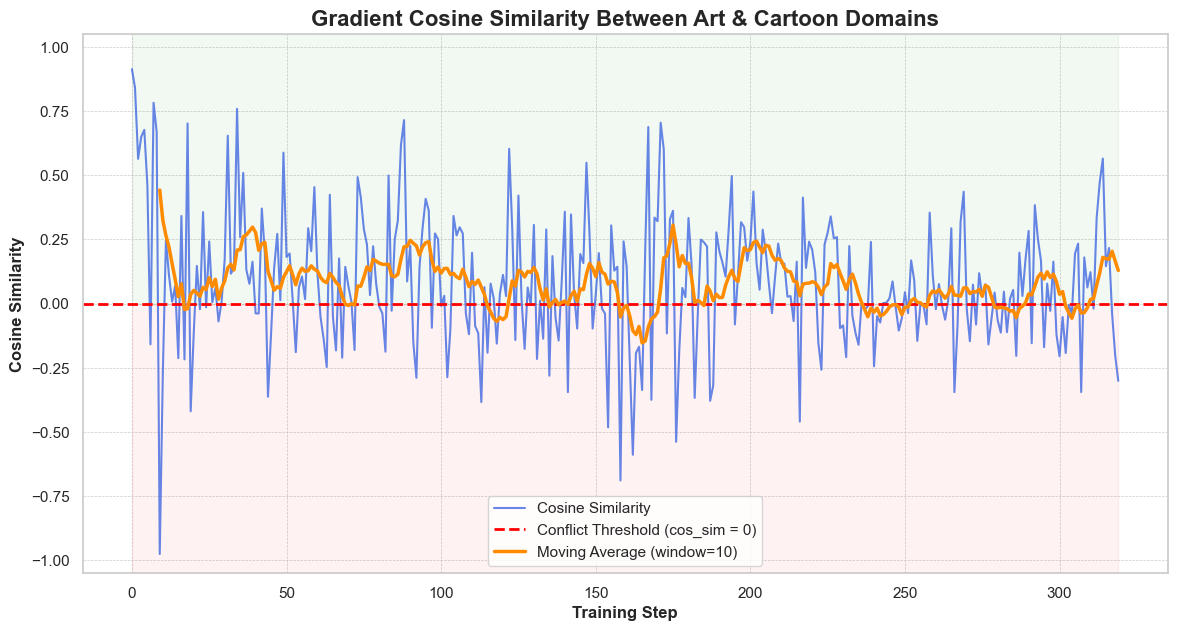

In [12]:
# ============================================
# 📊 Plot the Results
# ============================================
plt.figure(figsize=(14, 7))

# Plot the cosine similarity values
plt.plot(cosine_similarities, label='Cosine Similarity', color='royalblue', alpha=0.8)

# Add a horizontal line at y=0 to indicate the conflict threshold
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Conflict Threshold (cos_sim = 0)')

# Add a moving average to see the trend more clearly
window_size = 10
moving_avg = pd.Series(cosine_similarities).rolling(window=window_size).mean()
plt.plot(moving_avg, label=f'Moving Average (window={window_size})', color='darkorange', linewidth=2.5)

# --- Formatting ---
plt.title('Gradient Cosine Similarity Between Art & Cartoon Domains', fontsize=16, fontweight='bold')
plt.xlabel('Training Step', fontsize=12, fontweight='bold')
plt.ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=11)

# Annotate regions
plt.fill_between(range(len(cosine_similarities)), 0, -1.05, color='red', alpha=0.05, label='Conflict Region')
plt.fill_between(range(len(cosine_similarities)), 0, 1.05, color='green', alpha=0.05, label='Agreement Region')

plt.show()

---
## **Part 4: Open-Set and Generalization Analysis**

### **4.1. Overview**

A key strength of CLIP is its inherent **open-set recognition** capability, allowing it to classify images from any class described by a text prompt[cite: 169]. However, as hypothesized in the assignment manual, fine-tuning or prompt-tuning on a closed set of classes might diminish this ability. The model could become overconfident in its predictions for the classes it was trained on, making it less effective at identifying and rejecting samples from unseen classes (Out-of-Distribution, OOD)[cite: 203].

In this section, we will design an experiment to test this hypothesis:
1.  **Closed-Set Training**: We will split the 7 PACS classes into a 'seen' (in-distribution) set and an 'unseen' (OOD) set.
2.  **Re-train CoOp**: We will train our CoOp prompt-learning model *only* on the 'seen' classes.
3.  **Open-Set Evaluation**: We will evaluate both the original zero-shot CLIP and our specialized CoOp model on a test set containing samples from *all* classes. We'll analyze their confidence scores (Maximum Softmax Probability) to see which model is better at distinguishing seen from unseen data.

### **4.2. Setup and Re-training CoOp on the Closed Set**

In [ ]:
# ============================================
# 📂 Open-Set Class Definitions (Moved to Top)
# ============================================
# Original full class list from PACS
PACS_CLASSES_FULL = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]

# Split into seen (In-Distribution) and unseen (Out-of-Distribution) sets
SEEN_CLASSES = ["dog", "giraffe", "guitar", "house", "person"]  # 5 classes for training
UNSEEN_CLASSES = ["elephant", "horse"]  # 2 classes held out for OOD testing

# ============================================
# ⚙️ Re-Setup and Training for Closed-Set CoOp
# ============================================

# This is the original concatenation of the ImageFolder datasets (art, cartoon, photo)
source_datasets = [datasets[i] for i in range(len(DOMAINS)) if i != TARGET_DOMAIN_IDX]
source_concat_dataset_images = ConcatDataset(source_datasets)

# Get the integer indices for the 'seen' classes and create a label map
class_to_idx = datasets[0].class_to_idx
seen_class_indices = {class_to_idx[name] for name in SEEN_CLASSES}
label_map = {original_idx: new_idx for new_idx, original_idx in enumerate(sorted(list(seen_class_indices)))}

# Filter the ConcatDataset of ImageFolders to get indices of images from 'seen' classes
id_train_indices = []
for i in tqdm(range(len(source_concat_dataset_images)), desc="Filtering source dataset for seen classes"):
    original_label = source_concat_dataset_images[i][1]
    if original_label in seen_class_indices:
        id_train_indices.append(i)

# Create the final training dataset using the filtered indices
closed_set_train_dataset = Subset(source_concat_dataset_images, id_train_indices)
closed_set_train_loader = DataLoader(closed_set_train_dataset, batch_size=64, shuffle=True, num_workers=2)

print(f"\n✅ Created new image-based training loader with {len(closed_set_train_dataset)} samples from seen classes.")

# ============================================
# 🚀 Training Loop for Closed-Set CoOp
# ============================================
print("\n🚀 Starting Closed-Set CoOp training...")

# 1. Instantiate a new model, passing only the SEEN_CLASSES
closed_set_coop_model = CustomCLIPWithCoOp(SEEN_CLASSES, clip_model).to(device)

# 2. Freeze CLIP parameters
for name, param in closed_set_coop_model.named_parameters():
    if "ctx" not in name:
        param.requires_grad_(False)

# 3. Optimizer and Loss
optimizer_cs = optim.AdamW(closed_set_coop_model.prompt_learner.parameters(), lr=1e-2, weight_decay=1e-4)
criterion_cs = nn.CrossEntropyLoss()
lambda_entropy = 1.0
num_epochs_cs = 10

# 4. Set model to train
closed_set_coop_model.train()

for epoch in range(num_epochs_cs):
    target_iter_cs = iter(target_loader)
    running_sup_loss_cs = 0.0
    running_unsup_loss_cs = 0.0

    pbar_cs = tqdm(closed_set_train_loader, desc=f"Epoch {epoch+1}/{num_epochs_cs}")
    for images_s, labels_s in pbar_cs:
        # Handle label re-mapping for the loss function
        remapped_labels = torch.tensor([label_map[l.item()] for l in labels_s], dtype=torch.long).to(device)

        # Get target batch, cycling the iterator if needed
        try:
            images_t, _ = next(target_iter_cs)
        except StopIteration:
            target_iter_cs = iter(target_loader)
            images_t, _ = next(target_iter_cs)

        images_s, images_t = images_s.to(device), images_t.to(device)

        optimizer_cs.zero_grad()

        # --- Supervised Loss (Source - Seen Classes Only) ---
        logits_s = closed_set_coop_model(images_s)
        loss_sup = criterion_cs(logits_s, remapped_labels)

        # --- Unsupervised Entropy Loss (Target) ---
        logits_t = closed_set_coop_model(images_t)
        probs_t = logits_t.softmax(dim=-1)
        loss_unsup = (-(probs_t * torch.log(probs_t + 1e-9)).sum(dim=1)).mean()

        # --- Total Loss and Backward Pass ---
        total_loss = loss_sup + (lambda_entropy * loss_unsup)
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(closed_set_coop_model.prompt_learner.parameters(), 1.0)
        optimizer_cs.step()

        running_sup_loss_cs += loss_sup.item()
        running_unsup_loss_cs += loss_unsup.item()
        pbar_cs.set_postfix({
            'sup_loss': f"{loss_sup.item():.3f}",
            'unsup_loss': f"{loss_unsup.item():.3f}"
        })

    avg_sup_loss = running_sup_loss_cs / len(closed_set_train_loader)
    avg_unsup_loss = running_unsup_loss_cs / len(closed_set_train_loader)
    print(f"Epoch {epoch+1}/{num_epochs_cs} | Avg Sup Loss: {avg_sup_loss:.4f} | Avg Unsup Loss: {avg_unsup_loss:.4f}")

print("\n✅ Closed-Set CoOp training complete!")

Filtering source dataset for seen classes: 100%|██████████| 6062/6062 [00:09<00:00, 636.09it/s]



✅ Created new image-based training loader with 4424 samples from seen classes.

🚀 Starting Closed-Set CoOp training...
Initializing 16 context vectors randomly


Epoch 1/10: 100%|██████████| 70/70 [00:22<00:00,  3.07it/s, sup_loss=0.070, unsup_loss=0.133]


Epoch 1/10 | Avg Sup Loss: 0.0599 | Avg Unsup Loss: 0.0890


Epoch 2/10: 100%|██████████| 70/70 [00:22<00:00,  3.13it/s, sup_loss=0.024, unsup_loss=0.011]


Epoch 2/10 | Avg Sup Loss: 0.0375 | Avg Unsup Loss: 0.0409


Epoch 3/10: 100%|██████████| 70/70 [00:21<00:00,  3.18it/s, sup_loss=0.002, unsup_loss=0.009]


Epoch 3/10 | Avg Sup Loss: 0.0390 | Avg Unsup Loss: 0.0394


Epoch 4/10: 100%|██████████| 70/70 [00:22<00:00,  3.15it/s, sup_loss=0.210, unsup_loss=0.009]


Epoch 4/10 | Avg Sup Loss: 0.0330 | Avg Unsup Loss: 0.0356


Epoch 5/10: 100%|██████████| 70/70 [00:22<00:00,  3.17it/s, sup_loss=0.000, unsup_loss=0.009]


Epoch 5/10 | Avg Sup Loss: 0.0264 | Avg Unsup Loss: 0.0309


Epoch 6/10: 100%|██████████| 70/70 [00:21<00:00,  3.23it/s, sup_loss=0.000, unsup_loss=0.005]


Epoch 6/10 | Avg Sup Loss: 0.0264 | Avg Unsup Loss: 0.0290


Epoch 7/10: 100%|██████████| 70/70 [00:22<00:00,  3.07it/s, sup_loss=0.000, unsup_loss=0.011]


Epoch 7/10 | Avg Sup Loss: 0.0205 | Avg Unsup Loss: 0.0229


Epoch 8/10: 100%|██████████| 70/70 [00:21<00:00,  3.19it/s, sup_loss=0.035, unsup_loss=0.012]


Epoch 8/10 | Avg Sup Loss: 0.0191 | Avg Unsup Loss: 0.0162


Epoch 9/10: 100%|██████████| 70/70 [00:22<00:00,  3.11it/s, sup_loss=0.001, unsup_loss=0.008]


Epoch 9/10 | Avg Sup Loss: 0.0155 | Avg Unsup Loss: 0.0203


Epoch 10/10: 100%|██████████| 70/70 [00:22<00:00,  3.14it/s, sup_loss=0.001, unsup_loss=0.007]

Epoch 10/10 | Avg Sup Loss: 0.0135 | Avg Unsup Loss: 0.0129

✅ Closed-Set CoOp training complete!


### **4.3. Open-Set Evaluation & Analysis**

Now for the main analysis. We will evaluate both models on a test set containing **all 7 classes** from all 4 domains. For each image, we will record:
1.  Whether it's an In-Distribution (ID) or Out-of-Distribution (OOD) sample.
2.  The model's confidence in its prediction, measured by the **Maximum Softmax Probability (MSP)**.

A good open-set model should produce high MSP scores for ID samples and low MSP scores for OOD samples, allowing us to distinguish them with a simple confidence threshold.

In [14]:
# ============================================
# 🔬 Open-Set Evaluation Function
# ============================================

def evaluate_open_set(model, dataloader, id_class_indices, is_coop=False):
    model.eval()
    results = []
    
    # For Zero-Shot CLIP, we create text features for ALL classes
    if not is_coop:
        with torch.no_grad():
            prompts = [f"a photo of a {c}." for c in PACS_CLASSES_FULL]
            text_inputs = clip.tokenize(prompts).to(device)
            text_features = model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating Open-Set ({'CoOp' if is_coop else 'Zero-Shot'}) "):
            images, labels = images.to(device), labels.to(device)
            
            if is_coop:
                # CoOp model's forward pass gives logits for SEEN classes
                logits = model(images)
            else:
                # Zero-Shot: calculate logits manually
                image_features = model.encode_image(images.type(model.dtype))
                image_features /= image_features.norm(dim=-1, keepdim=True)
                logits = (100.0 * image_features @ text_features.T)
            
            msp, preds = logits.softmax(dim=-1).max(dim=-1)
            
            for i in range(len(labels)):
                is_id = labels[i].item() in id_class_indices
                results.append({
                    'msp': msp[i].item(),
                    'is_id': is_id
                })
                
    return pd.DataFrame(results)

# ============================================
# 🚀 Run Evaluation
# ============================================

# Create a combined dataloader with all domains for testing
full_test_dataset = ConcatDataset(datasets)
full_test_loader = DataLoader(full_test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Evaluate Zero-Shot CLIP
zero_shot_open_set_results = evaluate_open_set(clip_model, full_test_loader, seen_class_indices, is_coop=False)

# Evaluate our Closed-Set CoOp model
# Note: The CoOp model will only output logits for the 5 seen classes.
coop_open_set_results = evaluate_open_set(closed_set_coop_model, full_test_loader, seen_class_indices, is_coop=True)

print("\n✅ Open-set evaluation complete.")

Evaluating Open-Set (CoOp) : 100%|██████████| 79/79 [00:16<00:00,  4.89it/s]


✅ Open-set evaluation complete.


### **4.4. Analysis of MSP for OOD Detection**

Finally, we visualize the distributions of the Maximum Softmax Probability (MSP) for both models. A clear separation between the ID and OOD distributions indicates better open-set detection capability. We also calculate the False Positive Rate at 95% True Positive Rate (FPR@95), a standard metric for OOD detection.

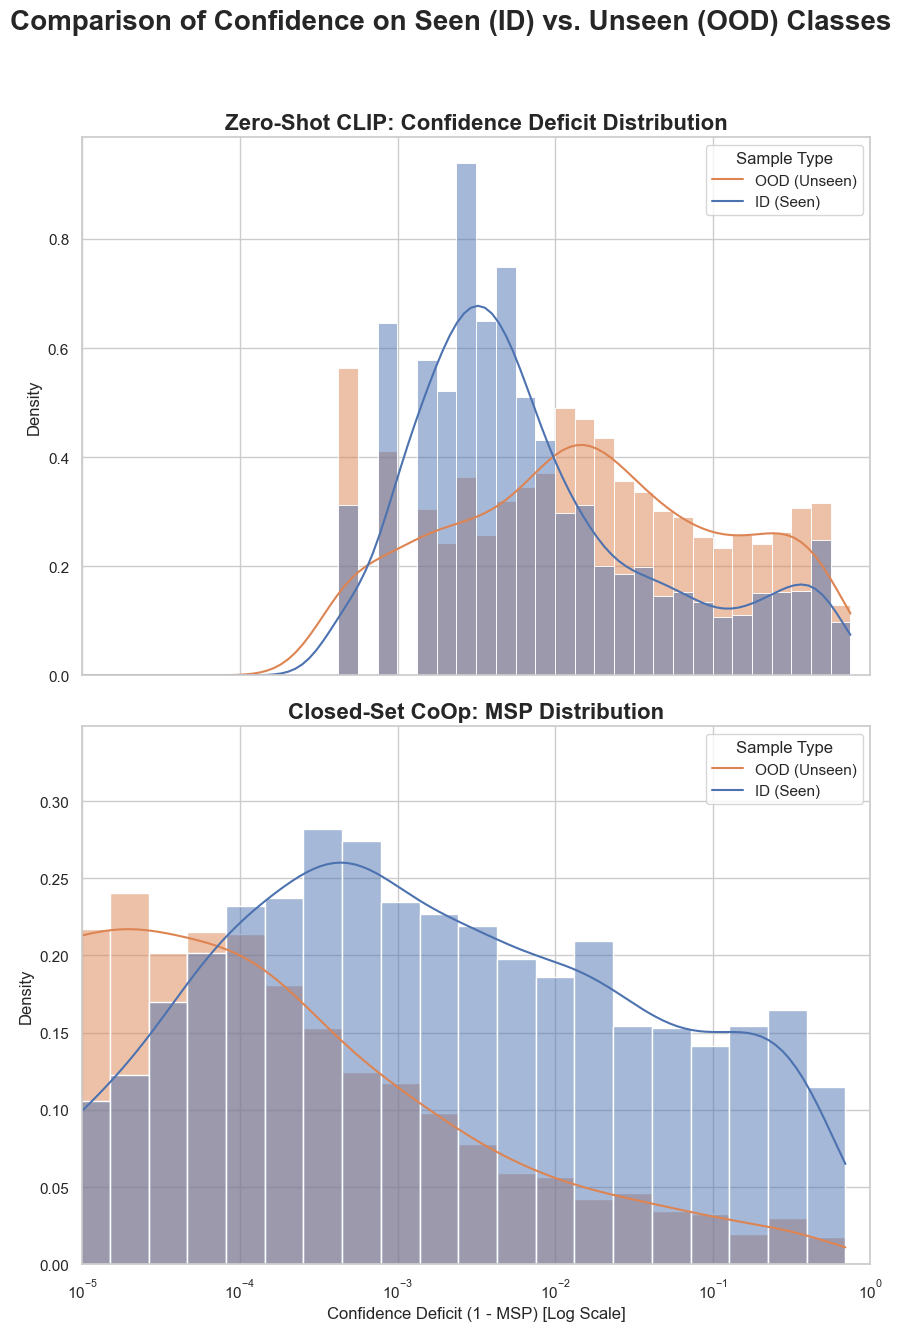

📊 Open-Set Detection Performance (Lower is better)
Zero-Shot CLIP FPR@95: 96.27%
Closed-Set CoOp FPR@95: 75.86%


In [ ]:
# ============================================
# 📊 Plot MSP Distributions
# ============================================

# Create a new column for "confidence deficit" (1 - MSP)
zero_shot_open_set_results['confidence_deficit'] = 1 - zero_shot_open_set_results['msp']
coop_open_set_results['confidence_deficit'] = 1 - coop_open_set_results['msp']

epsilon = 1e-9
zero_shot_open_set_results['confidence_deficit'] = zero_shot_open_set_results['confidence_deficit'].replace(0, epsilon)
coop_open_set_results['confidence_deficit'] = coop_open_set_results['confidence_deficit'].replace(0, epsilon)

# Subplot layout to 2 rows, 1 column; adjusted figure size; and shared the x-axis.
fig, axes = plt.subplots(2, 1, figsize=(9, 14), sharex=True)

# Plot for Zero-Shot CLIP
sns.histplot(data=zero_shot_open_set_results, x='confidence_deficit', hue='is_id', kde=True, ax=axes[0],
             stat='density', common_norm=False, log_scale=True)
axes[0].set_title('Zero-Shot CLIP: Confidence Deficit Distribution', fontsize=16, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend(title='Sample Type', labels=['OOD (Unseen)', 'ID (Seen)'])
axes[0].set_xlim(1e-5, 1) # Adjust x-limits for better visualization

# Plot for Closed-Set CoOp
sns.histplot(data=coop_open_set_results, x='confidence_deficit', hue='is_id', kde=True, ax=axes[1],
             stat='density', common_norm=False, log_scale=True)
axes[1].set_title('Closed-Set CoOp: MSP Distribution', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Confidence Deficit (1 - MSP) [Log Scale]', fontsize=12)

# Added y-label to the bottom plot for clarity.
axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend(title='Sample Type', labels=['OOD (Unseen)', 'ID (Seen)'])
axes[1].set_xlim(1e-5, 1) # Adjust x-limits for better visualization

fig.suptitle('Comparison of Confidence on Seen (ID) vs. Unseen (OOD) Classes', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ============================================
# 📉 Calculate FPR @ 95% TPR
# ============================================

def calculate_fpr95(df):
    y_true = df['is_id'].astype(int)
    y_score = df['msp']
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # Find the FPR at the TPR closest to 0.95
    idx = np.argmin(np.abs(tpr - 0.95))
    fpr_at_tpr95 = fpr[idx]
    return fpr_at_tpr95 * 100

fpr_zero_shot = calculate_fpr95(zero_shot_open_set_results)
fpr_coop = calculate_fpr95(coop_open_set_results)

print("="*50)
print("📊 Open-Set Detection Performance (Lower is better)")
print("="*50)
print(f"Zero-Shot CLIP FPR@95: {fpr_zero_shot:.2f}%")
print(f"Closed-Set CoOp FPR@95: {fpr_coop:.2f}%")
print("="*50)

### **4.5. Analysis of Learned Prompt Embeddings**

Finally, we address the last part of the analysis by comparing the learned prompt vectors themselves. The assignment asks how similar the prompts are when adapted to different data distributions. We can investigate this by calculating the **cosine similarity** between the prompt vectors (`ctx`) from our original `coop_model` (trained on all 7 classes) and our new `closed_set_coop_model` (trained on only 5 classes).

A low similarity would indicate that the prompt has become highly specialized to the closed-set classes, which would support our finding that its open-set performance has degraded.

In [16]:
# ============================================
# 🧠 Comparing Prompt Embeddings
# ============================================

# Ensure both models are on the same device
coop_model.to(device)
closed_set_coop_model.to(device)

# Get the learned context vectors (ctx) from both models
prompt_full_set = coop_model.prompt_learner.ctx
prompt_closed_set = closed_set_coop_model.prompt_learner.ctx

# The prompts are of shape (n_ctx, ctx_dim). We flatten them into a single vector for comparison.
prompt_full_set_flat = prompt_full_set.flatten()
prompt_closed_set_flat = prompt_closed_set.flatten()

# Calculate the cosine similarity
with torch.no_grad():
    similarity = F.cosine_similarity(prompt_full_set_flat, prompt_closed_set_flat, dim=0).item()

print("="*60)
print("🔬 Cosine Similarity Between Prompt Vectors")
print("="*60)
print(f"Original CoOp (7 classes) vs. Closed-Set CoOp (5 classes): {similarity:.4f}")
print("="*60)

🔬 Cosine Similarity Between Prompt Vectors
Original CoOp (7 classes) vs. Closed-Set CoOp (5 classes): 0.0680
